In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

import math, time, random, datetime

import numpy as np
import pandas as pd



In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


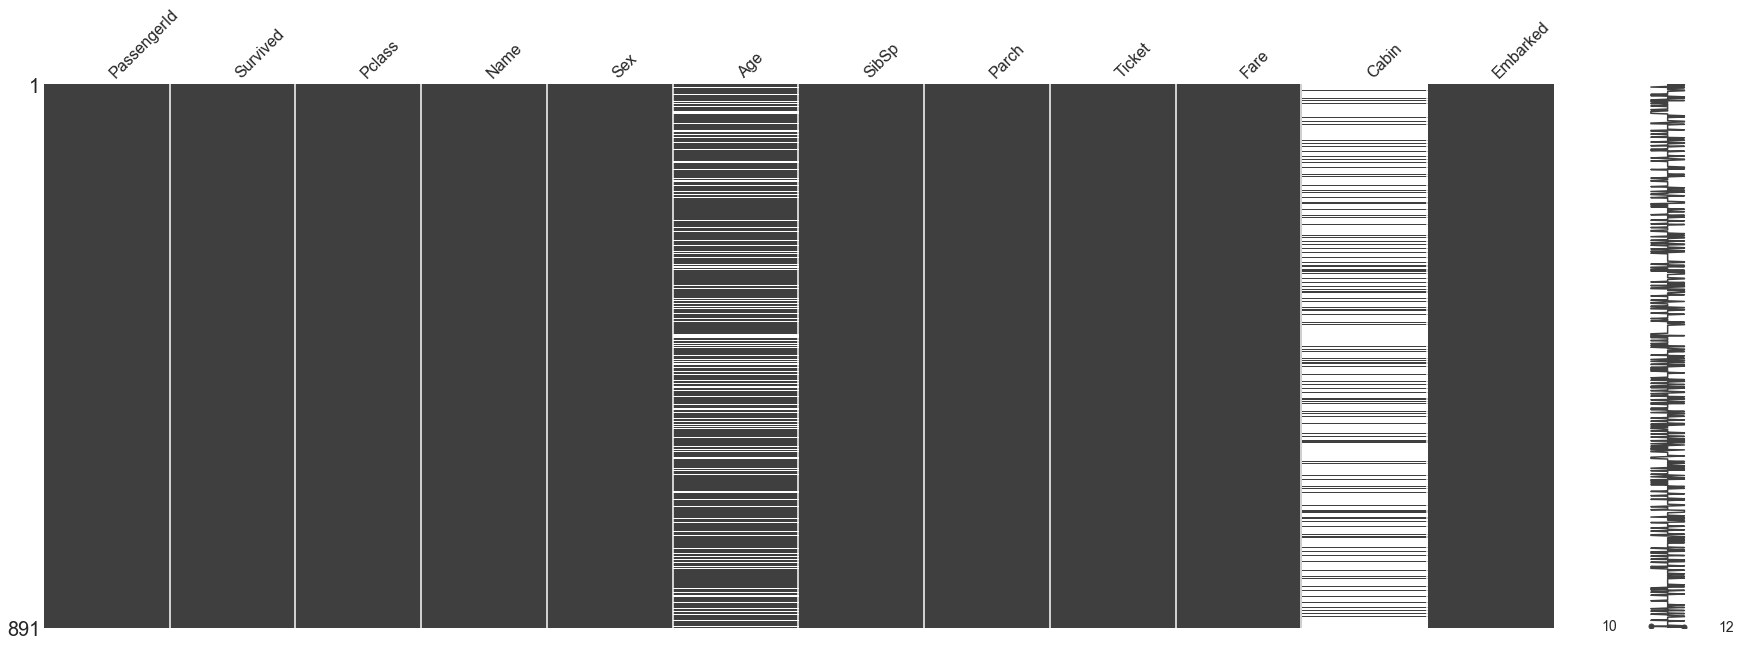

In [5]:
missingno.matrix(train, figsize = (30,10))

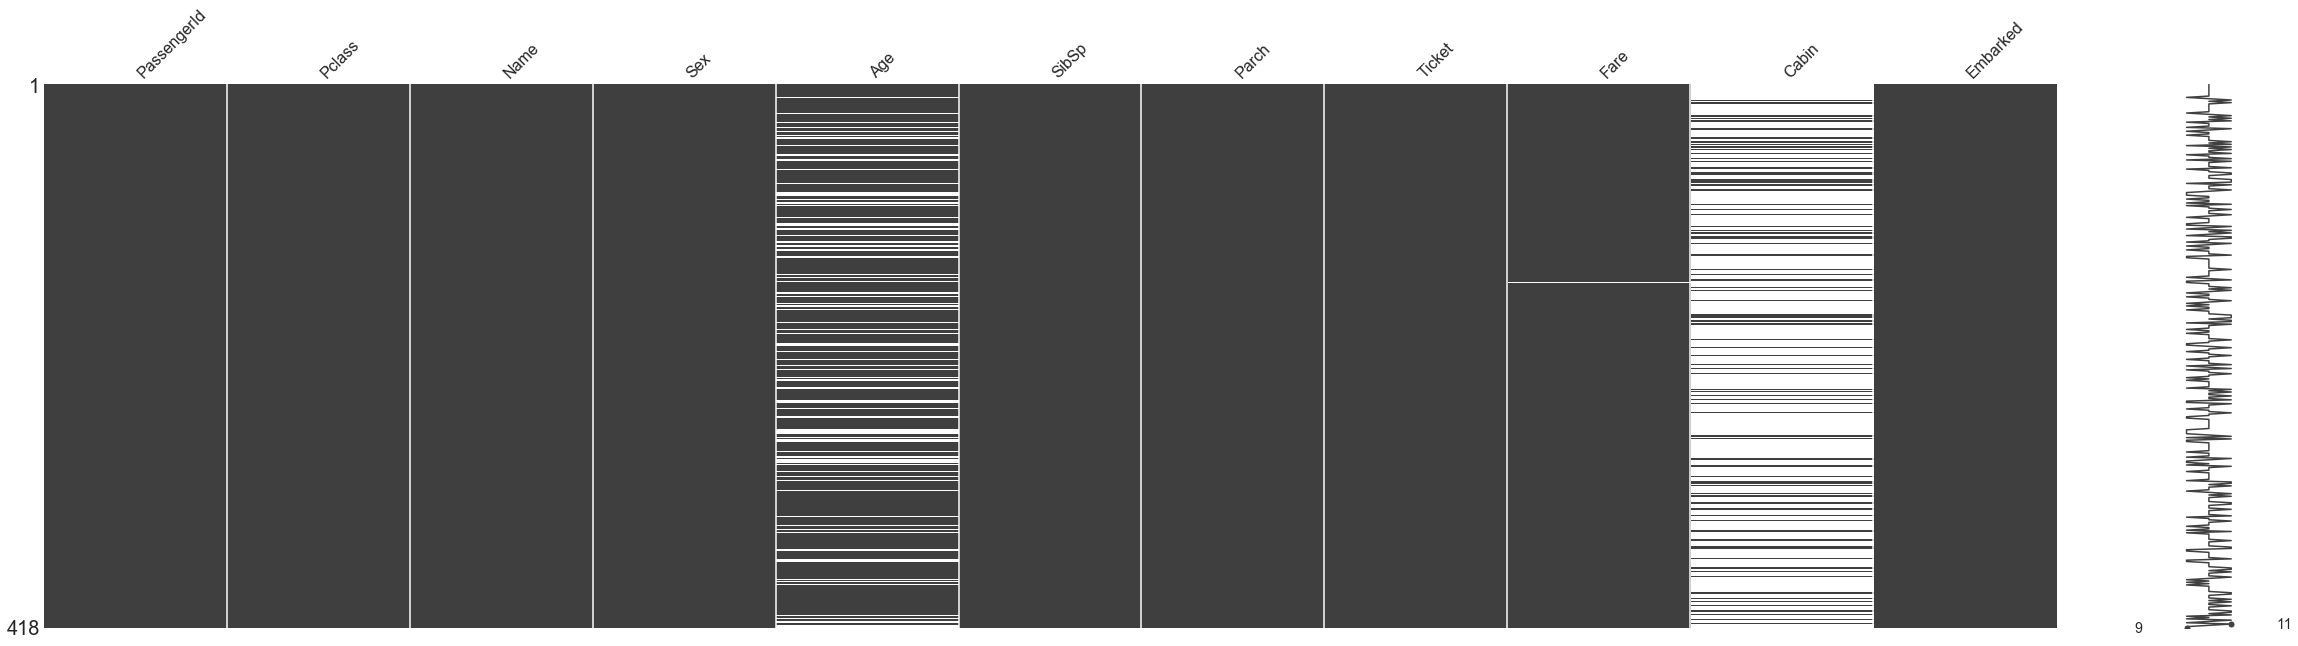

In [6]:
missingno.matrix(test, figsize = (40,10))

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [8]:
def get_title(name) :
    title = 'NA'
    if '.' in name :
        title = name.split(',')[1].split('.')[0].strip()
    if title in ['Dr', 'Rev', 'Col', 'Major', 'Don', 'Lady', 'Capt', 'Jonkheer', 'the Countess', 'Sir'] :
        return 'Rare'
    elif title in ['Mlle', 'Ms'] :
        return 'Miss'
    elif title in ['Mme'] :
        return 'Mrs'
    elif title not in ['Mr', 'Miss', 'Mrs', 'Master'] :
        return 'NA'
    else :
        return title

data = [train, test]
for dataset in data:
    dataset['Title'] = dataset['Name'].map(lambda x: get_title(x))
    dataset.drop(columns =["Name"], inplace = True)

In [9]:
for dataset in data:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.drop(columns =['SibSp', 'Parch'], inplace = True) 

In [10]:
for dataset in data:
    dataset.drop(columns =['PassengerId'], inplace = True) 
    dataset.drop(columns =['Ticket'], inplace = True)

In [11]:
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna('Unknown')
    dataset['Deck'] = dataset['Cabin'].map(lambda x: x[0])
    dataset.drop(columns =['Cabin'], inplace = True)

In [12]:
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean())

In [13]:
common_value = 'S'

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [14]:
def fill_age(title, age, sex, mean_age, std_age) :
    if np.isnan(age) :
        return np.random.randint(mean[title, sex] - std[title, sex], mean[title, sex] + std[title, sex])
    return age

mean = train.groupby(['Title', 'Sex']).mean()['Age']
std = train.groupby(['Title', 'Sex']).std()['Age']
for dataset in data:
    dataset['Age'] = dataset.apply(lambda x: fill_age(title = x['Title'], age = x['Age'], sex = x['Sex'], mean_age = mean, std_age = std), axis=1)

In [15]:
genders = {"male": 0, "female": 1}
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [16]:
ports = {"S": 0, "C": 1, "Q": 2}
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [17]:
normalize_cols = ['Age', 'Fare']
one_hot_cols = ['Pclass', 'Sex', 'Embarked', 'Title', 'Relatives', 'Deck']

In [18]:
for dataset in data:
    for col in normalize_cols :
        dataset[col] = (dataset[col] - dataset[col].mean()) / dataset[col].std()

In [19]:
train = pd.get_dummies(train, columns=one_hot_cols)
test = pd.get_dummies(test, columns=one_hot_cols)

In [20]:
train.head(15)

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,...,Relatives_10,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,0,-0.560114,-0.502163,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0.614638,0.786404,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,-0.266426,-0.488580,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0.394372,0.420494,1,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0.394372,-0.486064,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,0,-0.560114,-0.477848,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,1.789389,0.395591,1,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7,0,-2.028554,-0.223957,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
8,1,-0.193004,-0.424018,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
9,1,-1.147490,-0.042931,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [21]:
test.head(15)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,...,Relatives_7,Relatives_10,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,0.343335,-0.497811,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1.271148,-0.512660,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.384524,-0.464532,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,-0.213353,-0.482888,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.584478,-0.417971,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,-1.178278,-0.472814,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0.009323,-0.501392,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7,-0.287578,-0.118681,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,-0.881378,-0.508555,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9,-0.658703,-0.205535,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
